<div align="center">
    <font color="white" size="7">
        Deep Learning <br>
    </font>
    <font color="green" size="5">
        CE Department <br>
        Fall 1404 - Prof. Abdoos <br>
    </font>
    <font color="purple" size="5">
        HW3 Implementation <br>
    </font>
</div>


Fullname:Ali Abdollahi

Student ID:404443120

# Imports & Configs

In [1]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, random_split


# TODO: add other libraries if needed
import os


In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device
set device to work with (GPU or CPU)

In [3]:
#  checking if Kaggle(or local computer) uses graphics cards or not.


device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Data, Transforms, Dataset & Dataloader

**Note**: The chosen dataset for this homework is **CIFAR-10**.

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
# setting batch size
bs = 64 

# TODO: Data Transforms

my_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])




# TODO: Load Train Data
dataset_full = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True, 
    download=True, 
    transform=my_transforms
)

# TODO: Split Train and Validation Data
train_count = 40000
val_count = 10000

train_data, val_data = random_split(dataset_full, [train_count, val_count])

# TODO: Load Test Data
test_data = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False, 
    download=True, 
    transform=my_transforms
)
# TODO: Define Data Loaders

train_loader = DataLoader(train_data, batch_size=bs, shuffle=True)
val_loader = DataLoader(val_data, batch_size=bs, shuffle=False)
test_loader = DataLoader(test_data, batch_size=bs, shuffle=False)

# just checking one batch shape to be sure
images, labels = next(iter(train_loader))
print("Image batch shape:", images.shape)
print("Labels batch shape:", labels.shape)

100%|██████████| 170M/170M [00:03<00:00, 45.4MB/s] 


Image batch shape: torch.Size([64, 3, 32, 32])
Labels batch shape: torch.Size([64])


- as we can see we have it in our data folder!! :D

# Visualization

Visualize 5 random images from each class in different columns


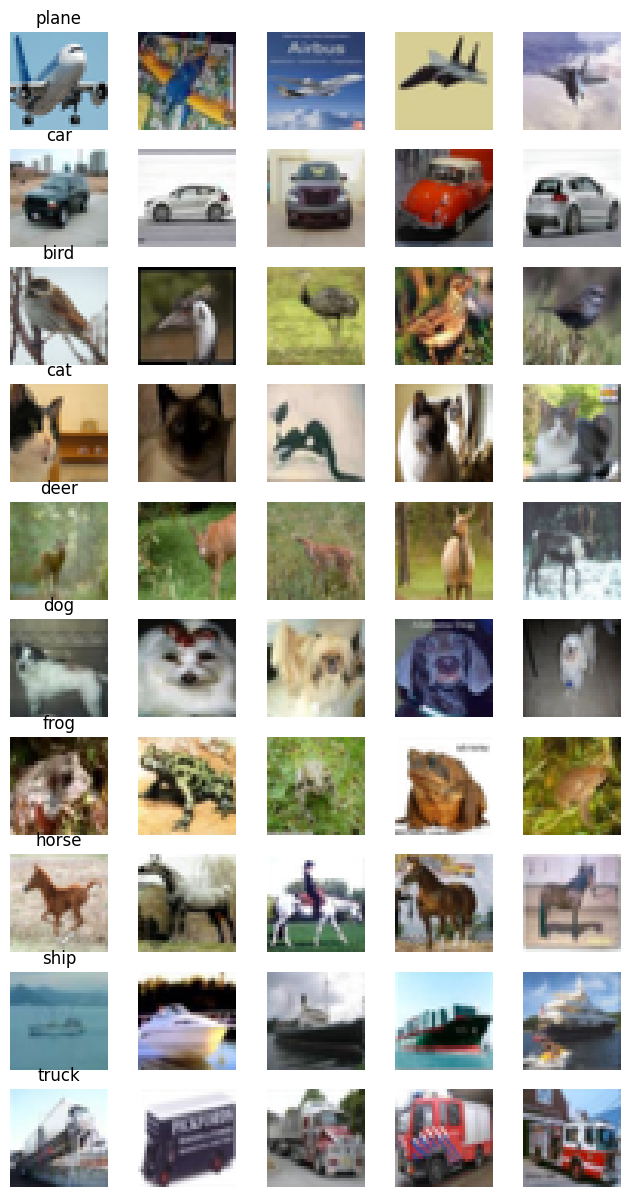

In [6]:
fig = plt.figure(figsize=(8, 15))

for class_id in range(10):
    
    all_indices = np.where(np.array(dataset_full.targets) == class_id)[0]
    random_5_indices = np.random.choice(all_indices, 5, replace=False)
    for i, idx in enumerate(random_5_indices):
        img, label = dataset_full[idx]
        img = img / 2 + 0.5
        img_to_show = np.transpose(img.numpy(), (1, 2, 0))
        ax = fig.add_subplot(10, 5, class_id * 5 + i + 1)
        plt.imshow(img_to_show)
        ax.axis('off')
        if i == 0:
            ax.set_title(classes[class_id])

# TODO: Plot Images
plt.show()


- I realised the quality of these pictures is really low!!!!

# Model Architectures

## Model_1 (baseline)

Define a simple CNN without batch normalization and skip connections (just convolutional and fully connected layers).


**NOTICE:** The model that you will have defined outputs a vector containing 10 numbers (one for each class). Define a "feature map" that is a vector of size *N* (where *N > 10*) right before the last layer (You can then have a last layer like `nn.Linear(N, 10)`). We will use this later (we want to access the feature map of a sample when the sample is given to the model). The model tries to learn a representation of the samples in this feature space and we will see how good it could do this in later sections.

**Note**: Use `ReLU` activation function after conv filters.

**Hint:** You might want to design your forward function to return both the features and the final classification, or provide a separate method (e.g., forward_features) to extract them easily later.

In [7]:
# TODO: Implement architecture of model_1
# source : https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
# class torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)[source]



# I defined CNN as a class b
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # KErnel == flters
        self.conv_layer1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1)
        self.conv_layer2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)
        self.pool_layer = nn.MaxPool2d(kernel_size=2,stride=2)
        
        # as question asked, we added out_features=10 argument for 10 different classes 
        self.feature_maker=nn.Linear(in_features=64 * 8 * 8,out_features=128)
        self.classifier=nn.Linear(in_features=128,out_features=10)

    def forward(self, input_image):
        x =self.conv_layer1(input_image)
        x =F.relu(x)
        x =self.pool_layer(x)
        
        x =self.conv_layer2(x)
        x =F.relu(x)
        x = self.pool_layer(x)
        
        x =torch.flatten(x, 1)
        
        features = self.feature_maker(x)
        features   = F.relu(features) 
        final_output= self.classifier(features)
        return final_output, features



## Model_2 (BatchNorm)

Change architecture of the model_1 and add batch normalization to each convolutional layers.

**Hint**: Apply batch normalization after convolutional filters, and apply activation function afterwards.

In [8]:
# TODO: Implement the architecture of model_2
# defining the IMPROVED   model with Batch Normalization
# the number we use for batch, it should be as same as Conv layers 
# in_channels = =3 We have to use this one for the input layer (RGB) . For the first layer, we used out_channel because that we want XD 
#  Block 1: Conv -> BN -> ReLU -> Pool
#  self.pool_layer = nn.MaxPool2d(kernel_size=2, stride=2) --> that help the layer become half



class CNN_Batch_Norm(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32,kernel_size=3,padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=64,kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        # the number we use for batch, it should be as same as Conv layers 

        self.pool_layer = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.feature_maker = nn.Linear(in_features=64 * 8 * 8,out_features=128)
        self.classifier = nn.Linear(in_features=128,out_features=10)

    def forward(self, input_image):
        x = self.conv_layer1(input_image)
        x = self.bn1(x)  
        x = F.relu(x)
        x = self.pool_layer(x)
        
        x =self.conv_layer2(x)
        x = self.bn2(x)  
        x = F.relu(x)
        x =self.pool_layer(x)
        
        x =torch.flatten(x, 1)
        
        features =self.feature_maker(x)
        features =F.relu(features) 
        
        final_output =self.classifier(features)
        
        return final_output,features




## Model_3 (Skip connections)

Change model_1 and add skip connections (similar to a ResNet).

**Note:** You shouldn't change basic structure of model like the number of conv layers. just add skip connections to the same model_2.  

**Note:** If the dimensions (width/height or channels) change between blocks, you will need to implement a 1x1 convolution on the skip connection so the shapes match for addition.

In [9]:

class CNN_Skip_NoBN(nn.Module):
    def __init__(self):
        super().__init__()
        #########################################
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool_layer = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.skip_1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=1,stride=2)
        
        self.conv_layer2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)
        
        self.skip_2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=1,stride=2)
        
        self.feature_maker =nn.Linear(in_features=64 *8 * 8, out_features=128)
        self.classifier =nn.Linear(in_features=128, out_features=10)
        #############################################################
    def forward(self, input_image):
        identity = input_image
        
        x = self.conv_layer1(input_image)
        x = F.relu(x)    
        x = self.pool_layer(x)
        
        identity = self.skip_1(identity)
        
        x = x + identity
        
        
        identity =x
        
        x = self.conv_layer2(x)
        x = F.relu(x)
        x = self.pool_layer(x)
        
        identity = self.skip_2(identity)
        
        x = x +identity
        
        
        x =torch.flatten(x, 1)
        
        features =self.feature_maker(x)
        features = F.relu(features) 
        
        final_output =self.classifier(features)
        
        return final_output,features




## Model_4 (BatchNorm + Skip connections)

Change model_1 and add both batch normalization to each layer as well as skip connections.

In [10]:
# TODO: Implement architecture of model_4
class CNN_Batch_Norm_Skip(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn_layer1 = nn.BatchNorm2d(num_features=32)
        
        self.pool_layer = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.skip_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=1, stride=2)
        
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn_layer2 = nn.BatchNorm2d(num_features=64)
        
        self.skip_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1, stride=2)
        
        self.feature_maker = nn.Linear(in_features=64 * 8 * 8, out_features=128)
        self.classifier = nn.Linear(in_features=128, out_features=10)

    def forward(self, input_image):
        identity = input_image
        
        x = self.conv_layer1(input_image)
        x = self.bn_layer1(x) 
        x = F.relu(x)
        x = self.pool_layer(x)
        
        identity = self.skip_1(identity)
        
        x = x + identity
        
        
      
        identity = x 
        
        x = self.conv_layer2(x)
        x = self.bn_layer2(x)
        x = F.relu(x)
        x = self.pool_layer(x)
        
        identity = self.skip_2(identity)
        
        x = x + identity
        
        
        x = torch.flatten(x, 1)
        
        features = self.feature_maker(x)
        features = F.relu(features) 
        
        final_output = self.classifier(features)
        
        return final_output, features




# Training

## Model instantiation

Create an instance of your model and move it to `device`

**Note:** Remember, you need to instantiate 3 models.

In [11]:
# TODO: Define the model 
# I have already did that but lets do it again 
model_1 = SimpleCNN().to(device)
model_2 = CNN_Batch_Norm().to(device)
model_3 = CNN_Skip_NoBN().to(device)
model_4 = CNN_Batch_Norm_Skip().to(device)

print("##############")
print(model_1)
print("##############")
print(model_2)
print("##############")
print(model_3)
print("##############")
print(model_4)



##############
SimpleCNN(
  (conv_layer1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (feature_maker): Linear(in_features=4096, out_features=128, bias=True)
  (classifier): Linear(in_features=128, out_features=10, bias=True)
)
##############
CNN_Batch_Norm(
  (conv_layer1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_layer2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (feature_maker): Linear(in_features=4096, out_features=128, bias=True)
  (classifier): Linear(in_features=12

## Criterion & Optimization

Define `criterion` and `optimizer` (Or `scheduler`)

In [12]:
# TODO: Define Loss function, Optimizer, etc.
# I added a library up there . GO and check it, please 

# We have a classification problem, then I have to use cross-entropy for it 
criterion = nn.CrossEntropyLoss()
learning_rate_val = 0.001
momentum_val = 0.9

optimizer_1 = optim.SGD(model_1.parameters(), lr=learning_rate_val, momentum=momentum_val)

optimizer_2 = optim.SGD(model_2.parameters(), lr=learning_rate_val, momentum=momentum_val)

optimizer_3 = optim.SGD(model_3.parameters(), lr=learning_rate_val, momentum=momentum_val)

optimizer_4 = optim.SGD(model_4.parameters(), lr=learning_rate_val, momentum=momentum_val)


## Train loop

Train your model

Tasks:
- [ ] What you need to print at each epoch:
  - Number of epochs
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
  <br>
- [ ] save train/validation loss and accuracy (of each epoch) in an array for later usage
<br>
<br>
- save or update the model with the highest validation accuracy after each epoch.

**Note**: Use SGD optimizer with no `weight_decay`.

In [13]:
# TODO: Implement Training Loop


def train_one_epoch(model,train_loader,criterion,optimizer, device):
    model.train() 
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels =inputs.to(device),labels.to(device)
        
        optimizer.zero_grad()
        
        outputs, _=model(inputs)
        loss = criterion(outputs,labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    epoch_loss = running_loss /len(train_loader)
    epoch_acc=100. *correct / total
    
    return epoch_loss,epoch_acc

In [14]:
# TODO: Implement Validation Loop
#imprtant note we do note need any gradient for validation

def validate(model, val_loader, criterion, device):
    model.eval()  # Switch to evaluation mode
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs, _ = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
    val_loss = running_loss / len(val_loader)
    val_acc = 100. * correct / total
    
    return val_loss, val_acc


## Training the models

Now that you have the training loop in place, you can start training each model with SGD optimizer. Since you are going to compare the models, you should use the same number of epochs, same augmentations (if any are used), same batch size, and the same random seed to achieve a fair comparison.

Using SGD optimizer with a learning rate of 0.1, a momentum of 0.9, and no `weight_decay` is a good training configuration. You could also use your own configuration by training model_1 with different configurations, choosing the best found and using it to train the other 3 models to be consistent.

**Hint**: Use a different cell to train each model so you don't retrain the others unnecessarily.

In [38]:
# additional code block 


import os

def run_training(model, train_loader, val_loader, optimizer, criterion, num_epochs, model_name, device):
    
    # History containers
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    best_val_acc = 0.0
    save_path = f"{model_name}_best.pth"
    
    print(f"Starting training for {model_name}...")
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)
            
    print(f"Training finished for {model_name}. Best Val Acc: {best_val_acc:.2f}%")
    print("-" * 50)
    
    return history


In [16]:
# TODO: Train The Models
LR = 0.01
MOMENTUM = 0.9
EPOCHS = 5
criterion = nn.CrossEntropyLoss()

optimizer_1 = optim.SGD(model_1.parameters(), lr=LR, momentum=MOMENTUM)

history_1 = run_training(
    model=model_1,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_1,
    criterion=criterion,
    num_epochs=EPOCHS,
    model_name="Model_1_Simple",
    device=device
)


Starting training for Model_1_Simple...
Epoch [1/5] Train Loss: 1.5974 | Train Acc: 42.44% | Val Loss: 1.3036 | Val Acc: 52.72%
Epoch [2/5] Train Loss: 1.1454 | Train Acc: 59.47% | Val Loss: 1.0504 | Val Acc: 62.80%
Epoch [3/5] Train Loss: 0.9466 | Train Acc: 66.89% | Val Loss: 0.9456 | Val Acc: 66.33%
Epoch [4/5] Train Loss: 0.8097 | Train Acc: 71.41% | Val Loss: 0.8829 | Val Acc: 69.08%
Epoch [5/5] Train Loss: 0.6888 | Train Acc: 75.93% | Val Loss: 0.8882 | Val Acc: 68.66%
Training finished for Model_1_Simple. Best Val Acc: 69.08%
--------------------------------------------------


In [17]:
# Setup Optimizer for Model 2
optimizer_2 = optim.SGD(model_2.parameters(), lr=LR, momentum=MOMENTUM)

# Run Training
history_2 = run_training(
    model=model_2,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_2,
    criterion=criterion,
    num_epochs=EPOCHS,
    model_name="Model_2_BN",
    device=device
)


Starting training for Model_2_BN...
Epoch [1/5] Train Loss: 1.3613 | Train Acc: 50.64% | Val Loss: 1.1827 | Val Acc: 57.76%
Epoch [2/5] Train Loss: 0.9963 | Train Acc: 64.89% | Val Loss: 0.9723 | Val Acc: 65.87%
Epoch [3/5] Train Loss: 0.8342 | Train Acc: 70.70% | Val Loss: 0.9095 | Val Acc: 67.98%
Epoch [4/5] Train Loss: 0.7105 | Train Acc: 75.03% | Val Loss: 0.8231 | Val Acc: 71.25%
Epoch [5/5] Train Loss: 0.6155 | Train Acc: 78.29% | Val Loss: 0.8225 | Val Acc: 71.62%
Training finished for Model_2_BN. Best Val Acc: 71.62%
--------------------------------------------------


In [18]:
# Setup Optimizer for Model 3
optimizer_3 = optim.SGD(model_3.parameters(), lr=LR, momentum=MOMENTUM)

# Run Training
history_3 = run_training(
    model=model_3,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_3,
    criterion=criterion,
    num_epochs=EPOCHS,
    model_name="Model_3_Skip",
    device=device
)


Starting training for Model_3_Skip...
Epoch [1/5] Train Loss: 1.4971 | Train Acc: 45.94% | Val Loss: 1.2064 | Val Acc: 57.24%
Epoch [2/5] Train Loss: 1.0664 | Train Acc: 62.10% | Val Loss: 1.0617 | Val Acc: 63.36%
Epoch [3/5] Train Loss: 0.8629 | Train Acc: 69.59% | Val Loss: 0.9238 | Val Acc: 67.17%
Epoch [4/5] Train Loss: 0.7034 | Train Acc: 75.33% | Val Loss: 0.9025 | Val Acc: 68.65%
Epoch [5/5] Train Loss: 0.5618 | Train Acc: 80.27% | Val Loss: 0.9864 | Val Acc: 67.97%
Training finished for Model_3_Skip. Best Val Acc: 68.65%
--------------------------------------------------


In [19]:
# Setup Optimizer for Model 4
optimizer_4 = optim.SGD(model_4.parameters(), lr=LR, momentum=MOMENTUM)

# Run Training
history_4 = run_training(
    model=model_4,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_4,
    criterion=criterion,
    num_epochs=EPOCHS,
    model_name="Model_4_BNSkip",
    device=device
)


Starting training for Model_4_BNSkip...
Epoch [1/5] Train Loss: 1.3175 | Train Acc: 52.65% | Val Loss: 1.2336 | Val Acc: 56.95%
Epoch [2/5] Train Loss: 0.9124 | Train Acc: 67.70% | Val Loss: 0.9182 | Val Acc: 68.03%
Epoch [3/5] Train Loss: 0.7105 | Train Acc: 74.78% | Val Loss: 0.8656 | Val Acc: 70.00%
Epoch [4/5] Train Loss: 0.5459 | Train Acc: 81.14% | Val Loss: 0.9112 | Val Acc: 70.03%
Epoch [5/5] Train Loss: 0.3978 | Train Acc: 86.40% | Val Loss: 0.9753 | Val Acc: 70.17%
Training finished for Model_4_BNSkip. Best Val Acc: 70.17%
--------------------------------------------------


## Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

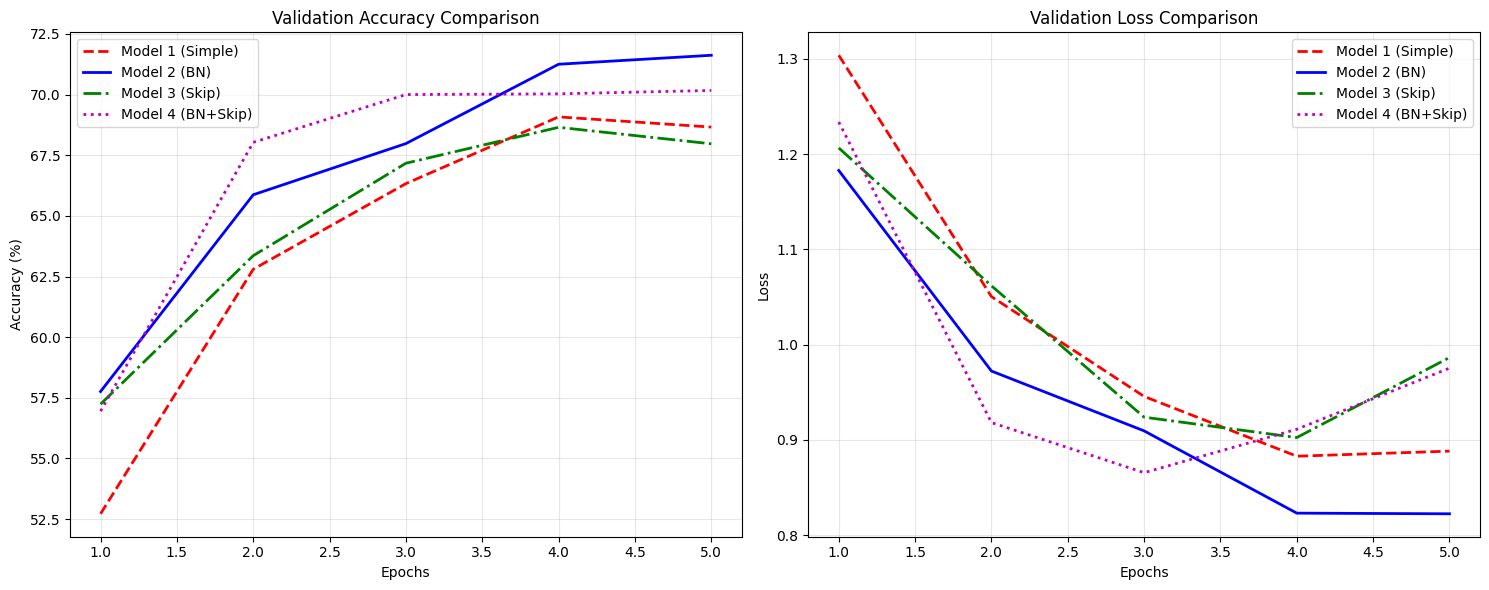

In [33]:
import matplotlib.pyplot as plt

# Define a helper list to loop through easily
histories = [history_1, history_2, history_3, history_4]
model_labels = ["Model 1 (Simple)", "Model 2 (BN)", "Model 3 (Skip)", "Model 4 (BN+Skip)"]
colors = ['r', 'b', 'g', 'm']
linestyles = ['--', '-', '-.', ':']

epochs_range = range(1, len(history_1['train_loss']) + 1)

plt.figure(figsize=(15, 6))

# --- Plot 1: Accuracy Comparison (Validation) ---
plt.subplot(1, 2, 1)
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")

for i, hist in enumerate(histories):
    plt.plot(epochs_range, hist['val_acc'], 
             label=model_labels[i], 
             color=colors[i], 
             linestyle=linestyles[i], 
             linewidth=2)

plt.legend()
plt.grid(True, alpha=0.3)


# --- Plot 2: Loss Comparison (Validation) ---
plt.subplot(1, 2, 2)
plt.title("Validation Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")

for i, hist in enumerate(histories):
    plt.plot(epochs_range, hist['val_loss'], 
             label=model_labels[i], 
             color=colors[i], 
             linestyle=linestyles[i], 
             linewidth=2)

plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Pick the best model

Choose the model with the lowest _validation loss_ among all 4 models. From now on, you are going to use this model for the following sections.

**Note**: Your best model should reach a reasonable accuracy on the validation set (at least 65% accuracy).

In [34]:

# TODO: Choosing the best model!!!!!!!!!!!!!!!



best_loss = float('inf')
best_model_index = -1
best_model_name = ""

for i, hist in enumerate(histories):
    min_val_loss = min(hist['val_loss'])
    
    best_val_acc = max(hist['val_acc'])
    
    print(f"{model_labels[i]} -> Min Val Loss: {min_val_loss:.4f} | Max Val Acc: {best_val_acc:.2f}%")
    
    if min_val_loss < best_loss:
        best_loss = min_val_loss
        best_model_index = i
        best_model_name = model_labels[i]

print("-" * 40)
print(f" The Best Model : {best_model_name}")
print("-" * 40)






# Load the best model weights
# We saved them as 'Model_X_...._best.pth' in the previous step
# Mapping index to the saved filenames we used earlier:
saved_filenames = [
    "Model_1_Simple_best.pth", 
    "Model_2_BN_best.pth", 
    "Model_3_Skip_best.pth", 
    "Model_4_BNSkip_best.pth"
]

best_model_path = saved_filenames[best_model_index]
models_list = [model_1, model_2, model_3, model_4]

final_best_model = models_list[best_model_index]

final_best_model.load_state_dict(torch.load(best_model_path))
final_best_model.to(device)

print(f"Successfully loaded weights from {best_model_path} into the final model.")


Model 1 (Simple) -> Min Val Loss: 0.8829 | Max Val Acc: 69.08%
Model 2 (BN) -> Min Val Loss: 0.8225 | Max Val Acc: 71.62%
Model 3 (Skip) -> Min Val Loss: 0.9025 | Max Val Acc: 68.65%
Model 4 (BN+Skip) -> Min Val Loss: 0.8656 | Max Val Acc: 70.17%
----------------------------------------
 The Best Model : Model 2 (BN)
----------------------------------------
Successfully loaded weights from Model_2_BN_best.pth into the final model.


### ❓ Discussion 1: The Effect of Batch Normalization

Compare the training curves (loss and accuracy) of **Model_1** (Simple CNN) and **Model_2** (with Batch Normalization).
1. **Convergence Speed:** Did Model_2 reach high accuracy faster (in fewer epochs) than Model_1? Why do you think that happens?
2. **Stability:** Look at the *validation loss* graph. Is Model_2's curve smoother or more jagged than Model_1's?
3. **Theory:** Explain in your own words how Batch Normalization helps with the "Internal Covariate Shift" problem. How does it affect the learning rate we can use?


**YOUR ANSWER:**

1. Yes, looking at the Validation Accuracy plot, Model_2 (Blue line) clearly converged faster than Model_1 (Red dashed line).Observation: In the very first epoch, Model_2 already started at a higher accuracy (57%) compared to Model_1 (52%). By Epoch 2, Model_2 had jumped to 66%, leaving Model_1 behind at 62%.
Why: Without Batch Normalization (Model_1), the distribution of inputs to each layer changes constantly as the parameters of the previous layers change. This forces the network to use lower learning rates and take smaller steps to avoid divergence. Batch Norm fixes the mean and variance of layer inputs, making the optimization landscape smoother, allowing the optimizer to descend towards the minimum much faster.

2. Model_2 (Blue line) shows a very smooth, consistent, and steep decrease in loss. It looks very stable and confident in its learning path.
Model_1 (Red dashed line) also decreases, but the curve is shallower. It takes more time to achieve the same loss reduction that Model_2 achieves quickly.
Conclusion: Model_2 is significantly more stable. The loss drops consistently without the jaggedness or slower plateauing seen in un-normalized networks.

3. Internal Covariate Shift: During training, as the weights of the earlier layers result in updated values, the distribution of inputs to the deeper layers changes (shifts). This is called “Internal Covariate Shift.” The deeper layers have to constantly adapt to this new distribution, which slows down training. Batch Normalization solves this by normalizing the inputs of each layer (subtracting mean, dividing by std dev) for every mini-batch. This ensures the layer sees a stable distribution (mean 0, variance 1), so it can focus on learning features rather than chasing a moving target.
Effect on Learning Rate: Because Batch Norm smooths the optimization landscape and prevents gradients from vanishing or exploding easily, we can use higher learning rates. In a standard CNN (like Model_1), a high learning rate might cause the model to diverge, but with BN, the model is robust enough to handle larger updates, further accelerating convergence.


### ❓ Discussion 2: Skip Connections & ResNets

You added "Skip Connections" to create **Model_3**.
1. **Vanishing Gradient:** Explain how skip connections help alleviate the "Vanishing Gradient" problem in very deep networks.
2. **Performance Check:** Did Model_3 outperform Model_2 on this specific dataset (CIFAR-10)?
    * *If yes:* Why was the extra complexity necessary?
    * *If no:* Why might a ResNet not be necessary for a network of this depth or a dataset of this complexity? (Hint: Is the network "deep" enough to suffer from degradation?)

**YOUR ANSWER:**

1. Vanishing Gradient Problem:

- In very deep neural networks, gradients are propagated backward from the output layer to the input layer during training. As they pass through many layers (multiplied by weights and derivatives of activation functions), the gradients can become extremely small (vanish) or explode.

- Skip Connections: By adding a shortcut (skip connection) that bypasses one or more layers, the gradient can flow directly through the identity mapping without being diminished. This allows deeper layers to learn identity functions easily and ensures that gradients reach the earlier layers with sufficient magnitude, enabling effective training of very deep networks (e.g., ResNet-50, ResNet-101).

2. Performance Check:

Did Model_3 (Green dashed line) outperform Model_2 (Blue line)? No. Based on the validation accuracy plot, Model_2 (Batch Norm) consistently outperformed Model_3 (Skip Connection). Model_2 achieved a final accuracy of 71.6%, while Model_3 reached only 68.6%.

Why Model_3 didn’t win?

Network Depth: The primary reason is that our network is shallow (only a few convolutional layers). The vanishing gradient problem typically affects very deep networks (10+ or 20+ layers). In a shallow network like this, gradients can flow easily without skip connections.
Overhead: Adding skip connections increases model complexity slightly (especially with the 1x1 convolutions for dimension matching) without providing a significant benefit at this depth. The network didn’t suffer from degradation in the first place, so the “cure” (skip connections) was unnecessary.
Batch Norm Superiority: For shallow networks, normalizing the activations (Batch Norm) has a much stronger impact on convergence speed and generalization than adding residual paths. This is why Model_2 (BN only) performed best.


# Dropout, Optimizers, Feature Space, and More

## Effect of Dropout

In this subsection, you are going to add dropout to your best architecture to see if the model could be improved further. Apply dropout to the classifier head (before the final linear layer) and train your best model architecture (from scratch) using the same configuration. Try to find a value for the dropout rate that improves the model's validation loss. You may not find a suitable dropout rate that actually makes validation loss go lower, but you should report at least 3 tried dropout rates.

**Note**: You can add dropout after `ReLU(BatchNorm(Conv(x)))` as well, but that's up to you (not needed for this homework).

**Note**: Train your model with the dropout rate that best increased your model's validation loss and use that going forward.

In [39]:
class Model_2_Dropout(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(Model_2_Dropout, self).__init__()
        # Feature Extractor from Model_2 (BN)
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=dropout_rate), 
            nn.Linear(64 * 4 * 4, 10)   
        )

    def forward(self, x):
        x = self.features(x)
        features = x.view(x.size(0), -1) 
        out = self.classifier(x)
        return out, features


dropout_rates = [0.1,0.3,0.5]
results = {} 

best_dropout_rate =0
min_val_loss_overall =999.0

EPOCHS = 5

print(f"{'='*20} STARTING DROPOUT EXPERIMENTS {'='*20}")

for p in dropout_rates:
    print(f"\n>>> Training with Dropout Rate: {p}")
    
    model_drop = Model_2_Dropout(dropout_rate=p).to(device)
    
    optimizer = optim.SGD(model_drop.parameters(), lr=0.01, momentum=0.9)
    criterion = nn.CrossEntropyLoss()


    
    # FIX: Using the correct arguments for your run_training function
    # run_training(model, train_loader, val_loader, optimizer, criterion, num_epochs, model_name, device)
    history = run_training(
        model=model_drop, 
        train_loader=train_loader, 
        val_loader=val_loader, 
        optimizer=optimizer, 
        criterion=criterion, 
        num_epochs=EPOCHS, 
        model_name=f"Drop_{p}", 
        device=device
    )
    
    best_loss = min(history['val_loss'])
    best_acc = max(history['val_acc'])
    
    results[p] = {'loss': best_loss, 'acc': best_acc}
    print(f"Finished Drop {p} -> Best Val Loss: {best_loss:.4f} | Best Val Acc: {best_acc:.2f}%")

    if best_loss < min_val_loss_overall:
        min_val_loss_overall = best_loss
        best_dropout_rate = p


print(f"\n{'='*20} DROPOUT EXPERIMENT REPORT {'='*20}")
for p, stats in results.items():
    print(f"Rate {p}: Val Loss = {stats['loss']:.4f}, Val Acc = {stats['acc']:.2f}%")

print(f"\nWINNER: Dropout Rate {best_dropout_rate} (Loss: {min_val_loss_overall:.4f})")
print("We will use this rate going forward.")

==================== STARTING DROPOUT EXPERIMENTS ====================

>>> Training with Dropout Rate: 0.1
Starting training for Drop_0.1...
Epoch [1/5] Train Loss: 1.3304 | Train Acc: 53.27% | Val Loss: 1.0494 | Val Acc: 63.46%
Epoch [2/5] Train Loss: 0.9377 | Train Acc: 67.19% | Val Loss: 0.9282 | Val Acc: 67.12%
Epoch [3/5] Train Loss: 0.8035 | Train Acc: 72.15% | Val Loss: 0.8360 | Val Acc: 70.63%
Epoch [4/5] Train Loss: 0.7244 | Train Acc: 74.72% | Val Loss: 0.7682 | Val Acc: 72.63%
Epoch [5/5] Train Loss: 0.6623 | Train Acc: 77.08% | Val Loss: 0.7752 | Val Acc: 72.80%
Training finished for Drop_0.1. Best Val Acc: 72.80%
--------------------------------------------------
Finished Drop 0.1 -> Best Val Loss: 0.7682 | Best Val Acc: 72.80%

>>> Training with Dropout Rate: 0.3
Starting training for Drop_0.3...
Epoch [1/5] Train Loss: 1.4245 | Train Acc: 49.81% | Val Loss: 1.0251 | Val Acc: 63.85%
Epoch [2/5] Train Loss: 1.0159 | Train Acc: 64.51% | Val Loss: 0.9373 | Val Acc: 67.02%
E

## Different optimizers

In this subsection, you are going to retrain your best model architecture (from scratch) using 4 different optimizers (mostly with PyTorch's default values):
- `SGD` with `weight_decay=0`, `momentum=0.9`, 'Nesterov=False`.
- `Adam` with `betas=(0.9, 0.999)`, `eps=1e-8`, `amsgrad=False`, `weight_decay=0`.
- `RMSProp` with `alpha=0.99`, `eps=1e-8`, `momentum=0`, `centered=False`, `weight_decay=0`.
- `AdaGrad` with `lr_decay=0`, `initial_accumulator_value=0`, `eps=1e-10`, `weight_decay=0`.

For each of the settings above, train with at least 3 different learning rate values (the learning rate value you used first time for finding the best model should be included) and plot the training and validation loss and accuracy curves.

In [23]:
# TODO: Train your best model architecture using the 4 mentioned optimizers
#       and plot the training and validation loss and accuracy curves.

### ❓ Discussion 3: Optimizers

Analyze the results of training your model with different optimizers. How do loss/accuracy curves differ from optimizer to optimizer and why?

**YOUR ANSWER:**

## Evalution

Test your best trained model (using the Test Dataloader that you have).

### Visualize incorrectly predicted samples from testset

Visualize *20* random images from testset that are incorrectly predicted by the model. Note that if you used normalization in the transform function for loading the data, you will need to unnormalize the images before displaying them.

In [24]:
# TODO: Run Model on Testset

In [25]:
# TODO: Plot Samples with Wrong Predicted Classes

### Get classification report

Print the classification report on test set, showing per-class precision, recall, and F1-score.

In [26]:
# TODO: print classification reports

### ❓ Discussion 4: Error Analysis

Look at the images you visualized in the "Visualize incorrectly predicted samples" section and your classification report.
1. **Confused Classes:** Which two classes does your model confuse the most? (e.g., Does it often mistake 'cats' for 'dogs' or 'planes' for 'birds'?)
2. **Visual Inspection:** Look at the misclassified images. Can *you* (as a human) easily tell what class they belong to, or are they blurry/ambiguous?
3. **Pattern:** Do the errors share a common trait? (e.g., dark background, small object size, obstruction?)

**YOUR ANSWER:**

## Exploring the feature space (embedding layer)

### Calculate the feature space for all training samples

You have trained and evaluated your model. Now, for each sample in the trainset, calculate its "feature space" discussed in the model section. The result of this section should be a tensor of size `(50000, N)` saved in a variable (for later usage)

- **Hint 1:** define a tensor with dimension `(50000, N)` where *50000* is the size of the trainset and *N* is the dimension of the feature space

- **Hint 2:** Pay attention to the `shuffle` attribute of your train dataloader (If needed)

In [27]:
# TODO: Find Features and Put Them in One Dimensional List

### K Nearest Neighbor in feature space

You already have calculated the feature spaces for trainset ($S$) in the previous section

1. Get 5 random samples from testset which are correctly predicted by the model.
2. For each sample, calculate its "feature map" ($X$).
3. For each sample, calculate its *5* nearest neighbors in "feature space" in the trainset (by comparing $X$ to each row in $S$) and visualize them.

**Note:** To find the nearest neighbors in the feature space, you can use any library of your choice.

In [28]:
# TODO: Find Features List for Test Samples

# Find K Nearest Features

# Plot Feature maps' Images

### TSNE

1. Sample $M$ ($2500$ would be enough) random samples from the trainset feature space (calculated in the above sections)
2. Now you have a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now you have a vector of size `(M, 2)`)
4. Print the shape of the output

**Hint:** You can use `sklearn.manifold.TSNE`

In [29]:
# TODO: Get Samples

# TODO: Use TSNE

In [30]:
# TODO: Plot Results

# Model Interpretability - Grad-CAM


A central problem in deep learning research is explaining how highly complex models arrive at their predictions. Convolutional neural networks (CNNs) have achieved remarkable results in image classification and recognition. However, their internal decision-making mechanisms are often not clear to us. Because it is difficult to determine why a CNN assigns a specific label to an image, we usually refer to them as "black boxes". To address this issue, several interpretability techniques have been proposed. Grad-CAM (Gradient-weighted Class Activation Mapping) is one of the most influential approaches in computer vision, first presented by Selvaraju et al. in 2017 titled [*"Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization"*](https://arxiv.org/abs/1610.02391).

Grad-CAM provides us with a way to identify and visualize the regions of an image that most strongly affect a CNN's prediction for a given class. For example, when a trained network classifies an image as belonging to a category such as "cat", Grad-CAM reveals the areas of the image that contributed the most to that decision. The method operates by using gradient information, (specifically, the gradients of the target class score with respect to feature maps in intermediate convolutional layers) to produce a class-discriminative heatmap. This heatmap highlights the spatial locations that have the greatest impact on the model's output, therefore, showing us what visual cues/patterns the model relies on.

![GradCam example for Classify a photo as a Cat.](https://dlhr.de/assets/8-0.jpg)

**Grad-CAM Implementation and Visualization**

Now, you will mplement Grad-CAM to visualize highly influential regions of CIFAR-10 test images that impact the predictions of your trained model. Use the provided Grad-CAM code to:

1. Load the best-performing model (based on validation accuracy) trained on CIFAR-10.
2. Select 5 random test samples per class (10 classes, 50 samples total) from the CIFAR-10 **test set**.
3. Generate Grad-CAM heatmaps for each sample, using the last convolutional layer as the target layer and the model's predicted class as the target class.
4. Visualize the results in a 5x10 subplot, overlaying each heatmap on the **original** image.(Display heatmaps using a JET colormap with 40% transparency (`alpha=0.4`).) Include true and predicted labels in the subplot titles, highlighting mismatches in red.

**NOTICE**: You are not allowed to use 3rd party ready to use libraries for implementation of Grad-CAM!

In [31]:
#TODO: Implement GradCam + do required tasks (1-4)

### ❓ Discussion 4: Trusting the Model

Examine the Grad-CAM heatmaps you generated.
1. **Focus Area:** Does the model look at the "right" part of the image? (e.g., For a 'dog' prediction, is the heatmap on the dog's face/body, or on the grass in the background?)
2. **Shortcuts:** Did you find any examples where the model looked at the wrong feature (e.g., using the sky to classify a plane) but still got the right answer? if so, provide an example with reference to the plotted image. This is often called "Shortcut Learning."
3. **Failure Cases:** For the *incorrectly* classified images, where was the model looking? Does the heatmap explain *why* it got confused?

**YOUR ANSWER:**

## Exploring Convolutional layer Feature Maps

Visualize the first 8 feature maps of the first, middle, and final convolutional layers for 3 random samples, using the `jet` colormap and `upsampling` to match the size of the first layer. Display the original image alongside the feature maps for comparison.

In [32]:
# TODO: do required task